In [ ]:
import nltk
import os
from nltk.corpus.reader.plaintext import PlaintextCorpusReader
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from scipy import sparse

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing the considered data sets (Train, Test\) that you mentioned within your email.

Note: For more clarification, I have to explaine a little more about the needed features that I have utlized in this chalenge. The first feature is text which is our independent variable, moreover, the second feature is star_rating that is used as our target(dependent) variable.

**IMPORT DATASET**

In [ ]:
train = pd.read_json('/content/drive/MyDrive/SST2_Train.json')

In [ ]:
train

,text,label
0,"a stirring , funny and finally transporting re...",positive
1,apparently reassembled from the cutting - room...,negative
2,they presume their audience wo n ' t sit still...,negative
3,this is a visually stunning rumination on love...,positive
4,jonathan parker ' s bartleby should have been ...,positive
...,...,...
7442,jose campanella delivers a loosely autobiograp...,positive
7443,". . . mafia , rap stars and hood rats butt the...",positive
7444,i got a headache watching this meaningless dow...,negative
7445,montias . . . pumps a lot of energy into his n...,positive


In [ ]:
test = pd.read_json('/content/drive/MyDrive/SST2_Test.json')

**ANALYZING AND MANAPULATING DATASET FOR BETTER KNOWING:**

In [ ]:
# The type of the labels based on the output are 'positive' and 'negative'. For ease of use, I convert these values into 1 and -1, respectively.
pd.unique(train.label)

array(['positive', 'negative'], dtype=object)

In [ ]:
# # Sentiment is a substitution for the label. Moreover, sentiment is a numerical vector compared to the label, making it easy to work with numerical values.
lst_1 = []
for i in train["label"]:
  if i == "positive":
    lst_1.append(1)
  else:
    lst_1.append(0)

train["sentiment"] = lst_1

In [ ]:
train

,text,label,sentiment
0,"a stirring , funny and finally transporting re...",positive,1
1,apparently reassembled from the cutting - room...,negative,0
2,they presume their audience wo n ' t sit still...,negative,0
3,this is a visually stunning rumination on love...,positive,1
4,jonathan parker ' s bartleby should have been ...,positive,1
...,...,...,...
7442,jose campanella delivers a loosely autobiograp...,positive,1
7443,". . . mafia , rap stars and hood rats butt the...",positive,1
7444,i got a headache watching this meaningless dow...,negative,0
7445,montias . . . pumps a lot of energy into his n...,positive,1


In [ ]:
# Sentiment is a substitution for the label. Moreover, sentiment is a numerical vector compared to the label, making it easy to work with numerical values.
lst_2 = []
for i in test["label"]:
  if i == "positive":
    lst_2.append(1)
  else:
    lst_2.append(0)

test["sentiment"] = lst_2

In [ ]:
test

,text,label,sentiment
0,"no movement , no yuks , not much of anything",negative,0
1,"a gob of drivel so sickly sweet , even the eag...",negative,0
2,"gangs of new york is an unapologetic mess , wh...",negative,0
3,"we never really feel involved with the story ,...",negative,0
4,this is one of polanski ' s best films,positive,1
...,...,...,...
1816,"an often deadly boring , strange reading of a ...",negative,0
1817,the problem with concept films is that if the ...,negative,0
1818,"safe conduct , however ambitious and well inte...",negative,0
1819,"a film made with as little wit , interest , an...",negative,0


+ DISTRIBUTION OF TARGET VALUES WITHIN THE TRAIN DATASET:

In [ ]:
# Distribution of target values is roughly normal
train["sentiment"].value_counts()

1    3893
0    3554
Name: sentiment, dtype: int64

*I had to do data preprocessing, but with searching on the papers and sites, I found that pre-trained models such as BERT, RoBerta and so on do not need to preprocessing because all of the words will convert into the tokens with spesific unicodes that are identified by LLMs.*

In [ ]:
# Seperating X_train , X_test , y_train and y_test from the data sets.
X_train = train["text"]
X_test = test["text"]

y_train = train["sentiment"]
y_test = test["sentiment"]

In [ ]:
y_train

0       1
1       0
2       0
3       1
4       1
       ..
7442    1
7443    1
7444    0
7445    1
7446    0
Name: sentiment, Length: 7447, dtype: int64

*** Bert ***

**Tokenization & Encoding**

BERT tokenization is used to convert the raw text into numerical inputs that can be fed into the BERT model. It tokenized the text and performs some preprocessing to prepare the text for the model’s input format. Let’s understand some of the key features of the BERT tokenization model.

-- BERT tokenizer adds special tokens like [CLS], [SEP], and [MASK] to the sequence. These tokens have special meanings like :

  + [CLS] is used for classifications and to represent the entire input in the case of sentiment analysis,

  + [SEP] is used as a separator i.e. to mark the boundaries between different sentences or segments,

  + [MASK] is used for masking i.e. to hide some tokens from the model during pre-training.

-- BERT tokenizer gives their components as outputs:
 + input_ids: The numerical identifiers of the vocabulary tokens
 + token_type_ids: It identifies which segment or sentence each token belongs to.
 + attention_mask: It flags that inform the model which tokens to pay attention to and which to disregard

**Tokenizer**

In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

In [ ]:
def defining_bert_tokenizer(PRE_TRAINED_MODEL_NAME):
    tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
    return tokenizer

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer=defining_bert_tokenizer(PRE_TRAINED_MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

 **Apply the BERT tokenization in training, testing and validation sets**

 In this step, we tokenize our training sets. In fact, tokenizer dedicates a number or unicode to each token that this matter has been shown in the down cells.

In [ ]:
# Tokenize and encode the sentences
X_train_encoded = tokenizer.batch_encode_plus(X_train.tolist(),
                                              padding=True,
                                              truncation=True,
                                              return_tensors='tf')

X_test_encoded = tokenizer.batch_encode_plus(X_test.tolist(),
                                              padding=True,
                                              truncation=True,
                                              return_tensors='tf')

In [ ]:
k = 0
print('Training Comments -->>', X_train[k])
print('\nInput Ids -->>\n',X_train_encoded['input_ids'][k])
print('\nDecoded Ids -->>\n',tokenizer.decode(X_train_encoded['input_ids'][k]))
print('\nAttention Mask -->>\n',X_train_encoded['attention_mask'][k])
print('\nLabels -->>',y_train[k])

Training Comments -->> a stirring , funny and finally transporting re - imagining of beauty and the beast and 1930s horror films

Input Ids -->>
 tf.Tensor(
[  101  1037 18385  1010  6057  1998  2633 18276  2128  1011 16603  1997
  5053  1998  1996  6841  1998  5687  5469  3152   102     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0], shape=(80,), dtype=int32)

Decoded Ids -->>
 [CLS] a stirring, funny and finally transporting re - imagining of beauty and the beast and 1930s horror films [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

In [ ]:
X_train_encoded

{'input_ids': <tf.Tensor: shape=(7447, 80), dtype=int32, numpy=
array([[  101,  1037, 18385, ...,     0,     0,     0],
       [  101,  4593,  2128, ...,     0,     0,     0],
       [  101,  2027,  3653, ...,     0,     0,     0],
       ...,
       [  101,  1045,  2288, ...,     0,     0,     0],
       [  101, 18318,  7951, ...,     0,     0,     0],
       [  101, 14308, 21354, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(7447, 80), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(7447, 80), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32

**Build the classification model**

In [ ]:
from transformers import TFBertForSequenceClassification
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import tensorflow as tf
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the model
model.fit(
    [X_train_encoded['input_ids'], X_train_encoded['token_type_ids'], X_train_encoded['attention_mask']],
    y_train,
    batch_size=16,
    epochs=5)

Epoch 1/5
466/466 [==============================] - 175s 283ms/step - loss: 0.0533 - accuracy: 0.9831
Epoch 2/5
466/466 [==============================] - 131s 281ms/step - loss: 0.0320 - accuracy: 0.9894
Epoch 3/5
466/466 [==============================] - 131s 281ms/step - loss: 0.0277 - accuracy: 0.9907
Epoch 4/5
466/466 [==============================] - 131s 281ms/step - loss: 0.0276 - accuracy: 0.9918
Epoch 5/5
466/466 [==============================] - 131s 281ms/step - loss: 0.0143 - accuracy: 0.9957


In [ ]:
y_pred = model.predict([X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']])

57/57 [==============================] - 10s 135ms/step


In [ ]:
# pred is of type TFSequenceClassifierOutput
logits = y_pred.logits

# Use argmax along the appropriate axis to get the predicted labels
pred_labels = tf.argmax(logits, axis=1)

# Convert the predicted labels to a NumPy array
pred_labels = pred_labels.numpy()

label = {
    1: 'positive',
    0: 'Negative'
}

# Map the predicted labels to their corresponding strings using the label dictionary
pred_labels = [label[i] for i in pred_labels]
Actual = [label[i] for i in y_test]

print('Predicted Label :', pred_labels[:20])
print('Actual Label    :', Actual[:20])

Predicted Label : ['Negative', 'Negative', 'Negative', 'Negative', 'positive', 'positive', 'Negative', 'positive', 'positive', 'Negative', 'positive', 'Negative', 'positive', 'positive', 'Negative', 'positive', 'positive', 'Negative', 'Negative', 'positive']
Actual Label    : ['Negative', 'Negative', 'Negative', 'Negative', 'positive', 'positive', 'Negative', 'positive', 'Negative', 'Negative', 'positive', 'Negative', 'Negative', 'positive', 'Negative', 'positive', 'positive', 'Negative', 'Negative', 'Negative']


**Evaluation Metrics**

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
print("Classification Report: \n", classification_report(Actual, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

    Negative       0.92      0.90      0.91       912
    positive       0.91      0.92      0.91       909

    accuracy                           0.91      1821
   macro avg       0.91      0.91      0.91      1821
weighted avg       0.91      0.91      0.91      1821



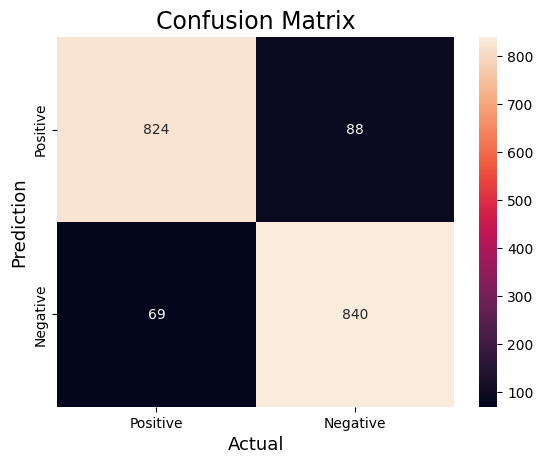

In [ ]:
#compute the confusion matrix
cm = confusion_matrix(Actual, pred_labels)

#Plot the confusion matrix
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Positive','Negative'],
            yticklabels=['Positive','Negative'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()